In [1]:
import os
os.environ.pop("CUDA_VISIBLE_DEVICES", None)

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

import tensorflow as tf
print("TF:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices("GPU"))


2025-12-05 05:55:16.372577: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764914116.567171      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764914116.620287      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

TF: 2.18.0
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
!pip -q install --no-deps "flwr==1.7.0" "iterators==0.0.2"

try:
    import flwr as fl
    from flwr.common import parameters_to_ndarrays
    HAVE_FLWR = True
    print("Flower:", fl.__version__)
except Exception as e:
    HAVE_FLWR = False
    print("Flower unavailable use offline FedAvg. Reason:", repr(e))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 8.1 MB/s eta 0:00:00
Flower: 1.7.0


In [3]:
import numpy as np, pandas as pd, re
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import random, os

SEED = 42
np.random.seed(SEED); random.seed(SEED)
import tensorflow as tf; tf.random.set_seed(SEED)

USE_FP16 = False
if USE_FP16:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy("mixed_float16")

In [4]:
import google.protobuf
from google.protobuf import message_factory as _mf
if not hasattr(_mf.MessageFactory, "GetPrototype"):
    def _get_prototype(self, descriptor):
        return self.GetMessageClass(descriptor)
    _mf.MessageFactory.GetPrototype = _get_prototype

try:
    from google.protobuf import symbol_database as _sd
    _sym_db = _sd.Default()
    if not hasattr(_sym_db, "GetPrototype") and hasattr(_sym_db, "GetMessageClass"):
        _sym_db.GetPrototype = _sym_db.GetMessageClass
except Exception:
    pass

print("protobuf:", google.protobuf.__version__, "(compat patch active)")


protobuf: 6.33.0 (compat patch active)


In [5]:
# /kaggle/input/ciciot2023/CICIOT23/train/train.csv
# /kaggle/input/ciciot2023/CICIOT23/validation/validation.csv
# /kaggle/input/ciciot2023/CICIOT23/test/test.csv
BASE = Path("/kaggle/input/ciciot2023/CICIOT23")
PATH_TRAIN = BASE/"train"/"train.csv"
PATH_VAL   = BASE/"validation"/"validation.csv"
PATH_TEST  = BASE/"test"/"test.csv"

for p in [PATH_TRAIN, PATH_VAL, PATH_TEST]:
    assert p.exists(), f"파일을 찾을 수 없습니다: {p}"
print("Train/Val/Test CSV found")


Train/Val/Test CSV found


In [6]:
def load_csv(path):
    return pd.read_csv(path, low_memory=False)

df_train = load_csv(PATH_TRAIN)
df_val   = load_csv(PATH_VAL)
df_test  = load_csv(PATH_TEST)

# --- 이진 라벨 (Normal=0, Attack=1) ---
def to_bin(s):
    s = str(s).lower()
    return 0 if "benign" in s else 1

label_col = None
for c in ["Label","label"]:
    if c in df_train.columns:
        label_col = c; break
assert label_col, f"라벨 (Label/label) 없음: {df_train.columns[:20].tolist()}"

df_train["bin_label"] = df_train[label_col].map(to_bin)
df_val["bin_label"]   = df_val[label_col].map(to_bin)
df_test["bin_label"]  = df_test[label_col].map(to_bin)

# --- 공격 분류 ---
def normalize_cat(s: str) -> str:
    s = str(s).lower()
    if "ddos" in s: return "DDoS"
    if re.search(r"\bdo?s\b", s) or "dos_" in s or "dos-" in s: return "DoS"
    if ("recon" in s) or ("scan" in s) or ("portscan" in s) or ("hostdiscovery" in s) or ("osscan" in s): return "Recon"
    if ("web" in s) or ("sql" in s) or ("xss" in s) or ("http" in s) or ("commandinjection" in s): return "Web"
    if ("brute" in s) or ("dictionary" in s): return "BruteForce"
    if "mirai" in s: return "Mirai"
    if ("spoof" in s) or ("arp" in s) or ("dns_spoof" in s): return "Spoofing"
    return "Other"

cat_col = None
for c in ["Attack","Category","AttackCategory","attack_category","category"]:
    if c in df_train.columns: cat_col = c; break
if cat_col is None:
    df_train["AttackCategory"] = df_train[label_col].map(normalize_cat)
    df_val["AttackCategory"]   = df_val[label_col].map(normalize_cat)
    df_test["AttackCategory"]  = df_test[label_col].map(normalize_cat)
    cat_col = "AttackCategory"

def pick_numeric(df):
    num = df.select_dtypes(include=[np.number])
    num = num.loc[:, num.nunique() > 1]
    num = num.dropna(axis=1, how="any")
    return num

Xtr_df = pick_numeric(df_train)
Xva_df = pick_numeric(df_val)
Xte_df = pick_numeric(df_test)

cols = sorted(set(Xtr_df.columns) & set(Xva_df.columns) & set(Xte_df.columns))

if "bin_label" in cols:
    print("Found 'bin_label' in features. Removing for data leak prevention.")
    cols.remove("bin_label")

Xtr_df, Xva_df, Xte_df = Xtr_df[cols], Xva_df[cols], Xte_df[cols]

y_train = df_train["bin_label"].values.astype(int)
y_val   = df_val["bin_label"].values.astype(int)
y_test  = df_test["bin_label"].values.astype(int)

cat_train = df_train[cat_col].astype(str).values

print("Shapes:", Xtr_df.shape, Xva_df.shape, Xte_df.shape)


Found 'bin_label' in features. Removing for data leak prevention.
Shapes: (5491971, 43) (1176851, 43) (1176851, 43)


In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(Xtr_df.values)
X_val   = scaler.transform(Xva_df.values)
X_test  = scaler.transform(Xte_df.values)
input_dim = X_train.shape[1]
print("Input dim:", input_dim)


Input dim: 43


In [8]:
rng = np.random.RandomState(SEED)
cat_norm_train = pd.Series(cat_train).map(normalize_cat).values

atk_counts = pd.Series(cat_norm_train[y_train==1]).value_counts()
picks = list(atk_counts.index[:4])
print("Node categories:", picks)

idx_all = np.arange(len(y_train))
idx_ben = idx_all[y_train==0]; rng.shuffle(idx_ben)

MAX_BENIGN_PER_NODE = 30000
benign_per_node = min(len(idx_ben)//4, MAX_BENIGN_PER_NODE)
print("benign_per_node:", benign_per_node, "| total_benign:", len(idx_ben))

nodes = []
for i, c in enumerate(picks[:4]):
    s, e = i*benign_per_node, min((i+1)*benign_per_node, len(idx_ben))
    ben_take = idx_ben[s:e]
    atk_idx  = idx_all[(y_train==1) & (cat_norm_train==c)]
    if len(ben_take)==0 or len(atk_idx)==0:
        print(f"[Warn] Node{i+1}({c}) skipped"); continue
    take = min(len(ben_take), len(atk_idx))
    node_idx = np.concatenate([ben_take[:take], rng.choice(atk_idx, size=take, replace=False)])
    rng.shuffle(node_idx)
    nodes.append((X_train[node_idx], y_train[node_idx], c))
    print(f"Node{i+1}={c}: total={len(node_idx)} (benign={take}, attack={take})")

assert len(nodes) >= 4, "error"

from sklearn.model_selection import train_test_split
node_splits=[]
for Xn, yn, cname in nodes[:4]:
    Xtr, Xva, ytr, yva = train_test_split(Xn, yn, test_size=0.1, random_state=SEED, stratify=yn)
    node_splits.append(((Xtr,ytr),(Xva,yva),cname))

(X1_tr,y1_tr),(X1_va,y1_va),_ = node_splits[0]
(X2_tr,y2_tr),(X2_va,y2_va),_ = node_splits[1]
(X3_tr,y3_tr),(X3_va,y3_va),_ = node_splits[2]
(X4_tr,y4_tr),(X4_va,y4_va),_ = node_splits[3]


Node categories: ['DDoS', 'DoS', 'Mirai', 'Spoofing']
benign_per_node: 30000 | total_benign: 129538
Node1=DDoS: total=60000 (benign=30000, attack=30000)
Node2=DoS: total=60000 (benign=30000, attack=30000)
Node3=Mirai: total=60000 (benign=30000, attack=30000)
Node4=Spoofing: total=60000 (benign=30000, attack=30000)


In [9]:
from tensorflow import keras
from tensorflow.keras import layers

def to_cat(y): 
    return keras.utils.to_categorical(y, 2)

def create_model(hidden=[128, 64], act="relu", dropout=0.2, norm=True):
    inp = keras.Input(shape=(input_dim,))
    x = inp
    for u in hidden:
        x = layers.Dense(u, activation=act, kernel_initializer="he_normal")(x)
        if norm:
            x = layers.BatchNormalization()(x)  
        if dropout:
            x = layers.Dropout(dropout)(x)       
    out = layers.Dense(2, activation="softmax", dtype="float32")(x)
    m = keras.Model(inp, out)
    m.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return m


In [10]:
cb = [keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)]

central = create_model()
central.fit(X_train, to_cat(y_train),
            validation_data=(X_val, to_cat(y_val)),
            epochs=50, batch_size=1024, verbose=0, callbacks=cb)
_, acc_c = central.evaluate(X_test, to_cat(y_test), verbose=0)
print("[Centralized] Test ACC:", round(float(acc_c),4))

acc_self = {}
for i,((Xtr,ytr),(Xva,yva),cname) in enumerate(node_splits,1):
    m = create_model()
    m.fit(Xtr, to_cat(ytr),
          validation_data=(Xva, to_cat(yva)),
          epochs=50, batch_size=1024, verbose=0, callbacks=cb)
    _, a = m.evaluate(X_test, to_cat(y_test), verbose=0)
    acc_self[f"Node{i}"] = float(a)
print("[Self] Test ACCs:", acc_self)


2025-12-05 05:57:00.805078: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1764914220.806111      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
I0000 00:00:1764914227.052583      69 service.cc:148] XLA service 0x7a5ad400bf00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764914227.053268      69 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1764914227.358180      69 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1764914229.275799      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


[Centralized] Test ACC: 0.9934
[Self] Test ACCs: {'Node1': 0.9821804165840149, 'Node2': 0.9697863459587097, 'Node3': 0.8943018317222595, 'Node4': 0.7909446358680725}


In [11]:
ROUNDs = 5
LOCAL_EPOCHS = 1
BATCH = 1024

global_eval = create_model()

def server_eval_on_val(params_or_weights):
    try:
        weights = parameters_to_ndarrays(params_or_weights) if HAVE_FLWR else params_or_weights
    except Exception:
        weights = params_or_weights
    global_eval.set_weights(weights)
    loss, acc = global_eval.evaluate(X_val, to_cat(y_val), verbose=0)
    return float(loss), float(acc)

if HAVE_FLWR:
    class SaveBestFedAvg(fl.server.strategy.FedAvg):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.best_params=None; self.best_val=-1.0; self.round_hist=[]
        def aggregate_fit(self, server_round, results, failures):
            agg, m = super().aggregate_fit(server_round, results, failures)
            if agg is not None:
                _, val = server_eval_on_val(agg) 
                self.round_hist.append((server_round, val))
                if val > self.best_val:
                    self.best_val = val; self.best_params = agg
            return agg, m

    class IDSClient(fl.client.NumPyClient):
        def __init__(self, cid, X, y):
            self.X, self.y = X, y
            self.order = np.arange(len(X)); np.random.RandomState(SEED).shuffle(self.order)
            self.model = create_model()
        def get_parameters(self, config): return self.model.get_weights()
        def fit(self, parameters, config):
            self.model.set_weights(parameters)
            r = int(config.get("server_round", 1))
            frac = min(max(r,1), ROUNDs)/ROUNDs   
            n = max(1, int(len(self.order)*frac))
            idx = self.order[:n]
            self.model.fit(self.X[idx], to_cat(self.y[idx]),
                           epochs=LOCAL_EPOCHS, batch_size=BATCH, verbose=0)
            return self.model.get_weights(), n, {}
        def evaluate(self, parameters, config):
            self.model.set_weights(parameters)
            loss, acc = self.model.evaluate(self.X, to_cat(self.y), verbose=0)
            return float(loss), len(self.y), {"train_proxy_acc": float(acc)}

    def client_fn(cid: str):
        i = int(cid)
        data = [(X1_tr,y1_tr),(X2_tr,y2_tr),(X3_tr,y3_tr),(X4_tr,y4_tr)]
        return IDSClient(i, *data[i])

    strategy = SaveBestFedAvg(
        fraction_fit=1.0, fraction_evaluate=0.0,
        min_fit_clients=4, min_evaluate_clients=0, min_available_clients=4,
    )

    history = fl.simulation.start_simulation(
        client_fn=client_fn,
        num_clients=4,
        config=fl.server.ServerConfig(num_rounds=ROUNDs),
        strategy=strategy,
        client_resources={"num_cpus":1, "num_gpus":0.25},
        ray_init_args={"num_cpus":4, "num_gpus":1, "include_dashboard":False,
                       "runtime_env":{"env_vars":{"TF_FORCE_GPU_ALLOW_GROWTH":"true"}}},
    )

    best_w = parameters_to_ndarrays(strategy.best_params)
    global_eval.set_weights(best_w)
    _, acc_fl = global_eval.evaluate(X_test, to_cat(y_test), verbose=0)
    round_hist = strategy.round_hist
    print(f"[Federated(Flower)@Best-VAL] Test ACC: {acc_fl:.4f}")

else:
    def fedavg(weight_sets, sizes):
        total = float(np.sum(sizes))
        avg = [np.zeros_like(w) for w in weight_sets[0]]
        for ws, n in zip(weight_sets, sizes):
            for i, w in enumerate(ws): avg[i] += (n/total)*w
        return avg

    def offline_fedavg(build_model, trainsets, rounds=ROUNDs, local_epochs=LOCAL_EPOCHS, bs=BATCH):
        g = build_model()
        best_val=-1.0; best_w=None; round_hist=[]
        rng = np.random.RandomState(SEED)
        orders = [rng.permutation(len(X)) for (X,_) in trainsets]
        for r in range(1, rounds+1):
            ws_list=[]; sizes=[]
            frac = r/rounds
            for (X,y), ord_idx in zip(trainsets, orders):
                n = max(1, int(len(X)*frac)); idx = ord_idx[:n]
                m = build_model(); m.set_weights(g.get_weights())
                m.fit(X[idx], to_cat(y[idx]), epochs=local_epochs, batch_size=bs, verbose=0)
                ws_list.append(m.get_weights()); sizes.append(n)
            new_w = fedavg(ws_list, sizes)
            g.set_weights(new_w)
            global_eval.set_weights(new_w)
            _, val_acc = global_eval.evaluate(X_val, to_cat(y_val), verbose=0)
            round_hist.append((r, float(val_acc)))
            if val_acc > best_val:
                best_val = val_acc; best_w = [w.copy() for w in new_w]
        
        global_eval.set_weights(best_w)
        _, acc_fl = global_eval.evaluate(X_test, to_cat(y_test), verbose=0)
        return acc_fl, round_hist

    acc_fl, round_hist = offline_fedavg(lambda: create_model(),
                                        [(X1_tr,y1_tr),(X2_tr,y2_tr),(X3_tr,y3_tr),(X4_tr,y4_tr)])
    print(f"[Federated(offline)@Best-VAL] Test ACC: {acc_fl:.4f}")


INFO flwr 2025-12-05 06:04:51,135 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2025-12-05 06:04:55,773	INFO worker.py:2012 -- Started a local Ray instance.
/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py:2051: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(
INFO flwr 2025-12-05 06:05:00,336 | app.py:213 | Flower VCE: Ray initialized with resources: {'memory': 14498392474.0, 'object_store_memory': 6213596774.0, 'CPU': 4.0, 'node:172.19.2.2': 1.0, 'GPU': 1.0, 'node:__internal_head__': 1.0, 'accelerator_type:P100': 1.0}
INFO flwr 2025-12-05 06:05:00,336 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2025-12-05 06:05:00,337 | 

[Federated(Flower)@Best-VAL] Test ACC: 0.9675



[Centralized] Test ACC: 0.9934231266320035
Confusion Matrix:
 [[  25712    1997]
 [   5743 1143399]]
              precision    recall  f1-score   support

      Normal       0.82      0.93      0.87     27709
      Attack       1.00      1.00      1.00   1149142

    accuracy                           0.99   1176851
   macro avg       0.91      0.96      0.93   1176851
weighted avg       0.99      0.99      0.99   1176851


[Federated@Best-VAL] Test ACC: 0.967520102374897
Confusion Matrix:
 [[  23595    4114]
 [  34110 1115032]]
              precision    recall  f1-score   support

      Normal       0.41      0.85      0.55     27709
      Attack       1.00      0.97      0.98   1149142

    accuracy                           0.97   1176851
   macro avg       0.70      0.91      0.77   1176851
weighted avg       0.98      0.97      0.97   1176851



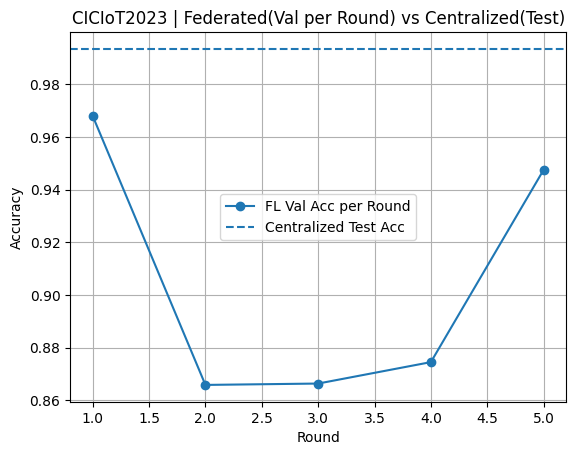

In [12]:
# 중앙집중 리포트
y_pred_c = np.argmax(central.predict(X_test, verbose=0), axis=1)
print("\n[Centralized] Test ACC:", accuracy_score(y_test, y_pred_c))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_c))
print(classification_report(y_test, y_pred_c, target_names=["Normal","Attack"]))

# 연합(베스트-VAL 가중치)
y_pred_fl = np.argmax(global_eval.predict(X_test, verbose=0), axis=1)
print("\n[Federated@Best-VAL] Test ACC:", accuracy_score(y_test, y_pred_fl))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_fl))
print(classification_report(y_test, y_pred_fl, target_names=["Normal","Attack"]))

# 라운드-VAL 정확도 vs 중앙집중 Test 정확도
rs = [r for (r,_) in round_hist]
accs = [a for (_,a) in round_hist]
plt.figure()
plt.plot(rs, accs, marker="o", label="FL Val Acc per Round")
plt.axhline(float(accuracy_score(y_test, y_pred_c)), ls="--", label="Centralized Test Acc")
plt.xlabel("Round"); plt.ylabel("Accuracy")
plt.title("CICIoT2023 | Federated(Val per Round) vs Centralized(Test)")
plt.grid(True); plt.legend(); plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if

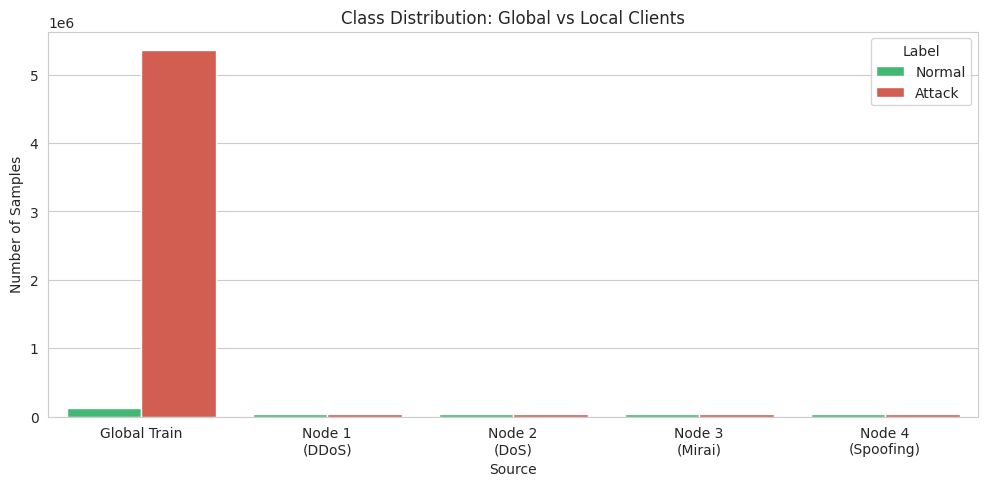

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if

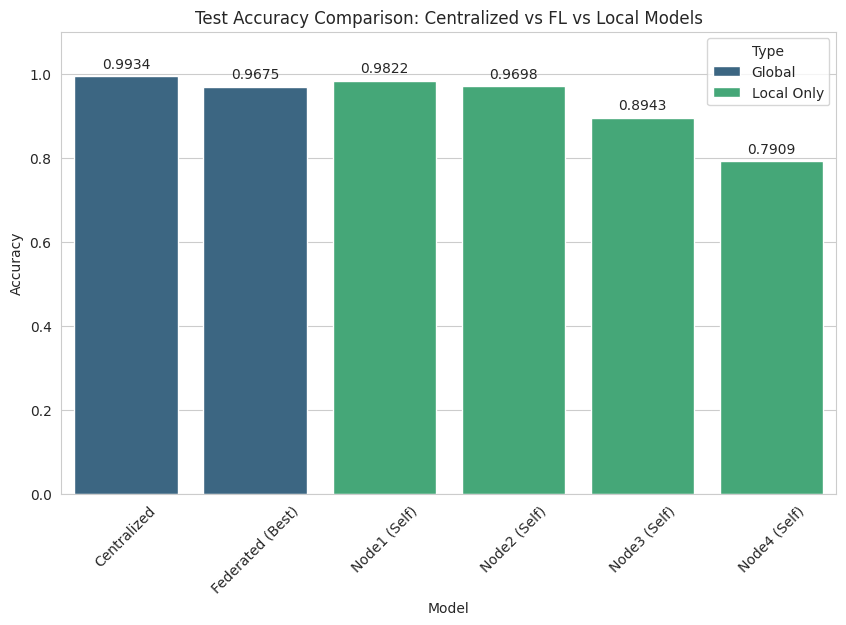

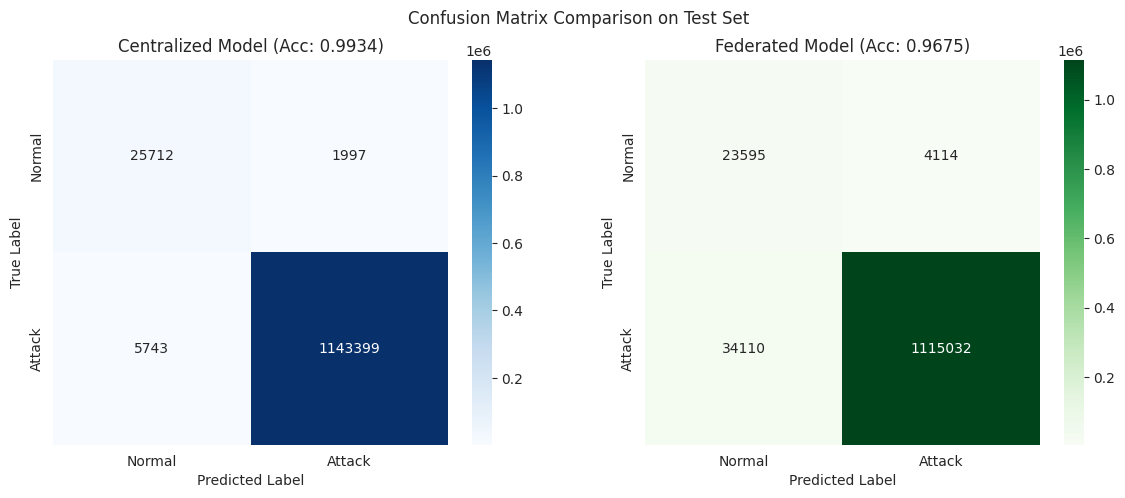

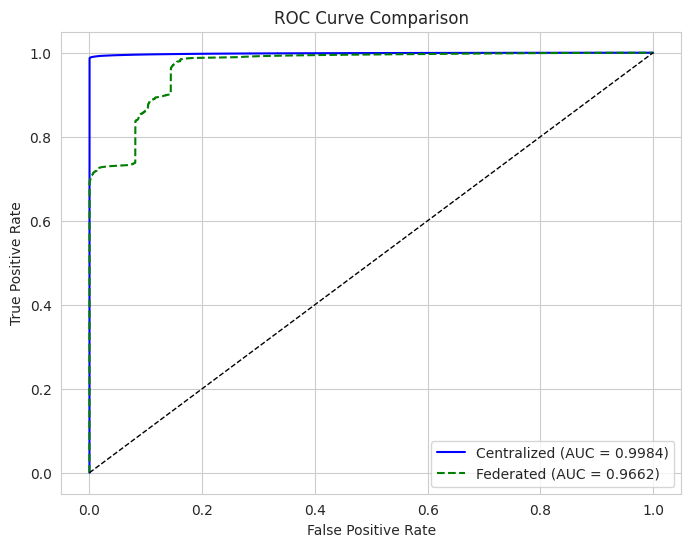

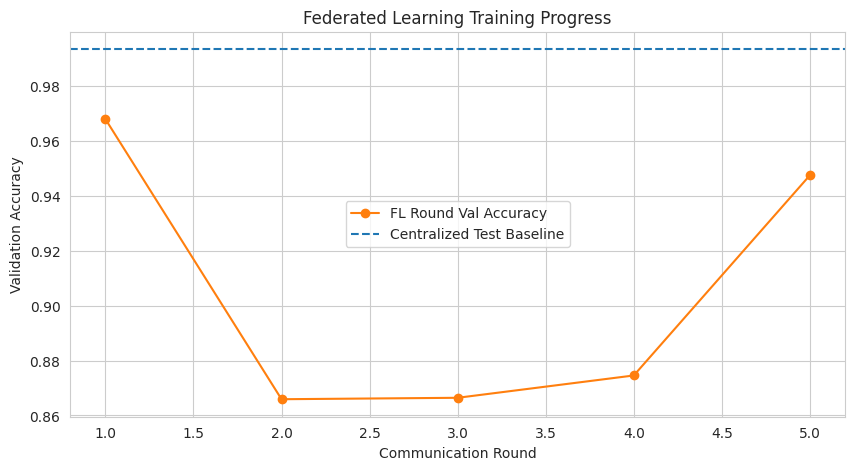

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix
import pandas as pd
import numpy as np

sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif' 

# ==========================================
# 1. 데이터 분포 시각화 (각 노드별 Benign/Attack 비율)
# ==========================================
def plot_data_distribution():
    data_info = []
    
    # Global Train
    unique, counts = np.unique(y_train, return_counts=True)
    for u, c in zip(unique, counts):
        data_info.append({"Source": "Global Train", "Label": "Attack" if u==1 else "Normal", "Count": c})

    # Nodes (Clients)
    for i, (Xn, yn, cname) in enumerate(nodes[:4]):
        unique, counts = np.unique(yn, return_counts=True)
        for u, c in zip(unique, counts):
            data_info.append({
                "Source": f"Node {i+1}\n({cname})", 
                "Label": "Attack" if u==1 else "Normal", 
                "Count": c
            })

    df_dist = pd.DataFrame(data_info)

    plt.figure(figsize=(12, 5))
    sns.barplot(data=df_dist, x="Source", y="Count", hue="Label", palette=["#2ecc71", "#e74c3c"])
    plt.title("Class Distribution: Global vs Local Clients")
    plt.ylabel("Number of Samples")
    plt.show()

# ==========================================
# 2. 모델별 정확도 비교 (Centralized vs FL vs Local)
# ==========================================
def plot_accuracy_comparison():
    # acc_c: Centralized, acc_fl: Federated, acc_self: Dict of Local Accs
    results = {
        "Model": ["Centralized", "Federated (Best)"],
        "Accuracy": [acc_c, acc_fl],
        "Type": ["Global", "Global"]
    }
    
    # Local 결과 추가
    for node_name, acc in acc_self.items():
        results["Model"].append(f"{node_name} (Self)")
        results["Accuracy"].append(acc)
        results["Type"].append("Local Only")
    
    df_res = pd.DataFrame(results)

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=df_res, x="Model", y="Accuracy", hue="Type", dodge=False, palette="viridis")
    
    # 값 표시
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.4f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', xytext = (0, 9), 
                    textcoords = 'offset points')
        
    plt.ylim(0, 1.1)
    plt.title("Test Accuracy Comparison: Centralized vs FL vs Local Models")
    plt.xticks(rotation=45)
    plt.show()

# ==========================================
# 3. Confusion Matrix 비교 (Centralized vs Federated)
# ==========================================
def plot_confusion_matrices():
    # Centralized
    cm_c = confusion_matrix(y_test, y_pred_c)
    # Federated
    cm_fl = confusion_matrix(y_test, y_pred_fl)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    sns.heatmap(cm_c, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
                xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
    axes[0].set_title(f"Centralized Model (Acc: {acc_c:.4f})")
    axes[0].set_ylabel("True Label")
    axes[0].set_xlabel("Predicted Label")

    sns.heatmap(cm_fl, annot=True, fmt='d', cmap='Greens', ax=axes[1],
                xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
    axes[1].set_title(f"Federated Model (Acc: {acc_fl:.4f})")
    axes[1].set_ylabel("True Label")
    axes[1].set_xlabel("Predicted Label")

    plt.suptitle("Confusion Matrix Comparison on Test Set")
    plt.show()

# ==========================================
# 4. ROC Curve 비교
# ==========================================
def plot_roc_curves():
    y_prob_c = central.predict(X_test, verbose=0)[:, 1]
    y_prob_fl = global_eval.predict(X_test, verbose=0)[:, 1]

    fpr_c, tpr_c, _ = roc_curve(y_test, y_prob_c)
    auc_c = auc(fpr_c, tpr_c)

    fpr_fl, tpr_fl, _ = roc_curve(y_test, y_prob_fl)
    auc_fl = auc(fpr_fl, tpr_fl)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_c, tpr_c, label=f'Centralized (AUC = {auc_c:.4f})', color='blue')
    plt.plot(fpr_fl, tpr_fl, label=f'Federated (AUC = {auc_fl:.4f})', color='green', linestyle='--')
    plt.plot([0, 1], [0, 1], 'k--', lw=1) 
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend(loc='lower right')
    plt.show()

# ==========================================
# 5. 연합학습 라운드별 성능 추이 (기존 그래프 개선)
# ==========================================
def plot_fl_history():
    if not round_hist:
        print("라운드 기록이 없습니다.")
        return

    rounds = [r for r, _ in round_hist]
    accs = [a for _, a in round_hist]
    
    plt.figure(figsize=(10, 5))
    plt.plot(rounds, accs, marker='o', linestyle='-', color='tab:orange', label='FL Round Val Accuracy')
    
    # Centralized Benchmark Line
    plt.axhline(y=acc_c, color='tab:blue', linestyle='--', label='Centralized Test Baseline')
    
    plt.xlabel("Communication Round")
    plt.ylabel("Validation Accuracy")
    plt.title("Federated Learning Training Progress")
    plt.legend()
    plt.grid(True)
    plt.show()

# --- 실행 ---
#print(">>> 1. 데이터 분포 그리기...")
plot_data_distribution()

#print("\n>>> 2. 정확도 비교 그리기...")
plot_accuracy_comparison()

#print("\n>>> 3. 오차 행렬(Confusion Matrix) 그리기...")
plot_confusion_matrices()

#print("\n>>> 4. ROC 곡선 그리기...")
plot_roc_curves()

#print("\n>>> 5. 학습 곡선 그리기...")
plot_fl_history()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


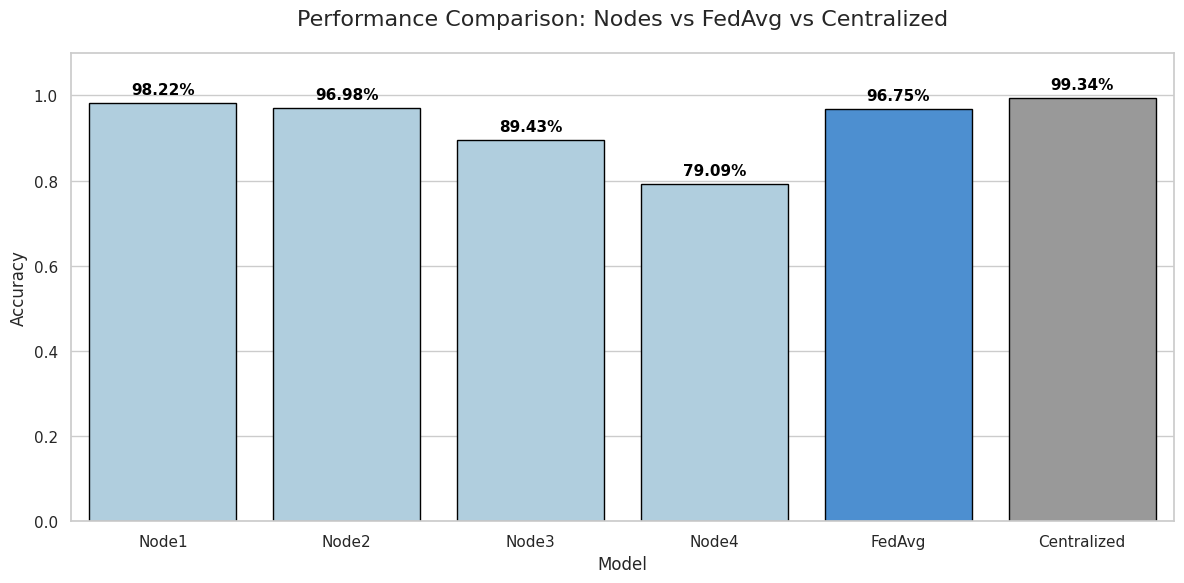

>>> Evaluating Global Model on Specific Attack Types...


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_c

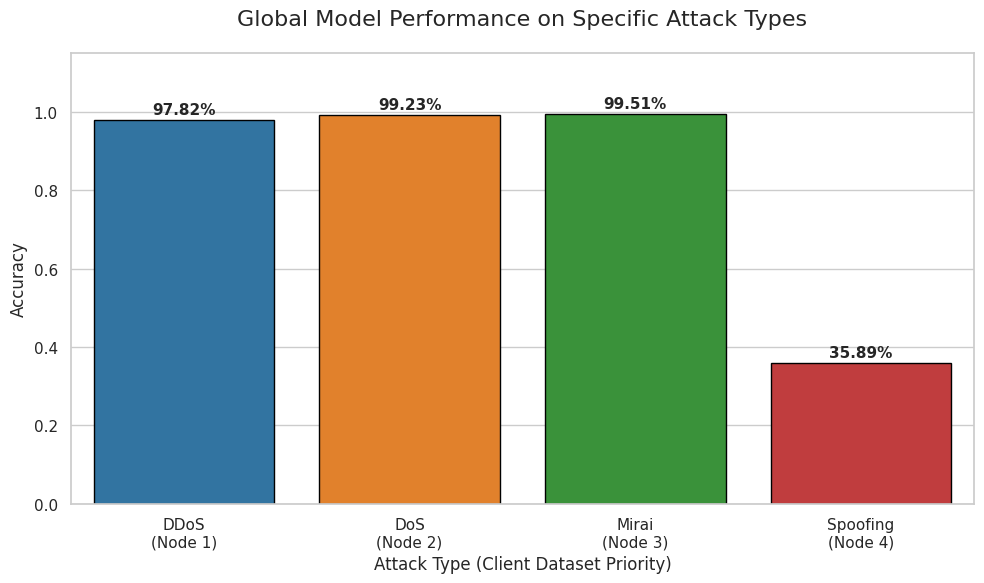

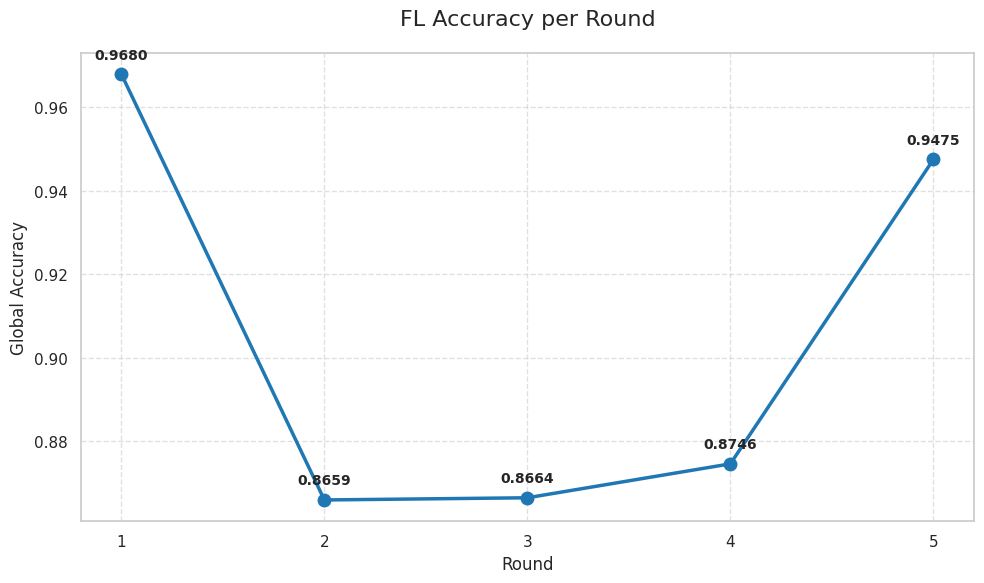

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set_theme(style="whitegrid")
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (10, 6)

# ==========================================
# 1. 종합 성능 비교 (Nodes vs FedAvg vs Centralized)
# ==========================================
def plot_comprehensive_comparison():
    labels = []
    scores = []
    colors = []
    
    # 1. Local Nodes (각 노드가 혼자 학습했을 때 성능)
    # acc_self 딕셔너리가 순서가 없을 수 있으므로 정렬
    sorted_nodes = sorted(acc_self.keys())
    for key in sorted_nodes:
        labels.append(key)
        scores.append(acc_self[key])
        colors.append("#a8d0e6")  # 연한 파랑 (Local)

    # 2. Federated Learning (FedAvg)
    labels.append("FedAvg")
    scores.append(acc_fl)
    colors.append("#378fe6")  # 진한 파랑 (FL)

    # 3. Centralized (중앙집중)
    labels.append("Centralized")
    scores.append(acc_c)
    colors.append("#999999")  # 회색 (Baseline)

    df_comp = pd.DataFrame({"Model": labels, "Accuracy": scores})

    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x="Model", y="Accuracy", data=df_comp, palette=colors, edgecolor="black")
    
    plt.title("Performance Comparison: Nodes vs FedAvg vs Centralized", fontsize=16, pad=20)
    plt.ylabel("Accuracy")
    plt.ylim(0, 1.1)  # 텍스트 들어갈 공간 확보

    # 막대 위에 퍼센트 표시
    for p in ax.patches:
        h = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., h + 0.015, 
                f"{h*100:.2f}%", 
                ha="center", va="bottom", fontsize=11, fontweight='bold', color='black')
    
    plt.tight_layout()
    plt.show()

# ==========================================
# 2. 공격 유형별 FL 모델 성능 (Specific Attack Types)
#    (이미지 3번 형태: 각 노드가 주로 보유했던 공격에 대해 FL 모델이 얼마나 잘하는지)
# ==========================================
def plot_attack_breakdown():
    # picks: 이전 코드에서 노드를 구성할 때 사용한 상위 4개 공격 카테고리
    # global_eval: 학습이 완료된 연합학습 모델
    
    attack_accs = []
    attack_labels = []
    
    print(">>> Evaluating Global Model on Specific Attack Types...")
    
    # picks 리스트 순서대로 (Node 1, 2, 3, 4의 주 공격유형)
    for i, attack_type in enumerate(picks[:4]):
        # 전체 테스트셋에서 해당 공격 유형만 필터링
        # cat_col, normalize_cat 등은 이전 코드 컨텍스트 사용
        mask = df_test[cat_col].map(normalize_cat) == attack_type
        
        if mask.sum() == 0:
            print(f"  [Skip] No test samples for {attack_type}")
            continue
            
        X_sub = X_test[mask] # 필터링된 피처
        y_sub = y_test[mask] # 필터링된 라벨
        
        # 모델 평가
        loss, acc = global_eval.evaluate(X_sub, to_cat(y_sub), verbose=0)
        
        attack_accs.append(acc)
        # 라벨 예: "DDoS (Node1)"
        attack_labels.append(f"{attack_type}\n(Node {i+1})")

    # 그래프 그리기
    plt.figure(figsize=(10, 6))
    # 공격 유형별로 다른 색상
    colors = sns.color_palette("tab10", n_colors=len(attack_labels))
    
    ax = sns.barplot(x=attack_labels, y=attack_accs, palette=colors, edgecolor="black")
    
    plt.title("Global Model Performance on Specific Attack Types", fontsize=16, pad=20)
    plt.ylabel("Accuracy")
    plt.xlabel("Attack Type (Client Dataset Priority)")
    plt.ylim(0, 1.15)

    for p in ax.patches:
        h = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., h + 0.015, 
                f"{h*100:.2f}%", 
                ha="center", fontsize=11, fontweight='bold')
        
    plt.tight_layout()
    plt.show()

# ==========================================
# 3. 라운드별 FL 정확도 추이 (Line Chart)
#    (이미지 5번 형태)
# ==========================================
def plot_fl_rounds_line():
    if not round_hist:
        print("라운드 기록(round_hist)이 없습니다.")
        return

    rounds = [r for r, _ in round_hist]
    accs = [a for _, a in round_hist]
    
    plt.figure(figsize=(10, 6))
    
    # 선 그래프 그리기
    plt.plot(rounds, accs, marker='o', markersize=9, linewidth=2.5, linestyle='-', color='#1f77b4')
    
    plt.title("FL Accuracy per Round", fontsize=16, pad=20)
    plt.xlabel("Round")
    plt.ylabel("Global Accuracy")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(rounds) # x축에 라운드 정수만 표시
    
    # 포인트마다 값 표시
    for x, y in zip(rounds, accs):
        plt.text(x, y + 0.003, f"{y:.4f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.show()

# --- 실행 ---
plot_comprehensive_comparison()
plot_attack_breakdown()
plot_fl_rounds_line()